In [1]:
from statsmodels.datasets import macrodata
from sklearn.preprocessing import StandardScaler
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

data = macrodata.load_pandas().data
X = data[['realgdp', 'realcons', 'realinv', 'realgovt',
          'realdpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values
y = data['cpi'].values

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x
        
    def fit(self, X, y, epochs, optimizer):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        
        optimizer(self, nn.MSELoss(), X_tensor, y_tensor, 
                                   max_iter=epochs, tol=1e-6)



In [3]:
def conjugate_gradient_optimizer(model, loss_fn, X, y, max_iter=1000, tol=1e-6):
    """ 
    Реалізація алгоритму навчання нейронної мережі за методом спряжених градієнтів
    """
   
    # Ініціалізація вагового вектора w та обчислення початкового градієнта G
    params = [p for p in model.parameters()]
    w = torch.cat([p.data.flatten() for p in params])
    
    def get_gradient():
        """Обчислити градієнт для поточних параметрів моделі."""
        model.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        return torch.cat([p.grad.flatten() for p in params])
    
    g = get_gradient()
    d = -g
    
    for i in range(max_iter):
        # КРОК 1: Знайти скаляр alpha*
        def objective(alpha):
            with torch.no_grad():
                w_new = w + alpha * d
                idx = 0
                for p in params:
                    size = p.numel()
                    p.data = w_new[idx:idx+size].reshape(p.shape)
                    idx += size
            output = model(X)
            return loss_fn(output, y).item()
        # Використання методу золотого перетину для пошуку alpha*
        alpha = golden_section_search(objective, 0, 1, tol=1e-4)
        w_new = w + alpha * d # Оновлення вагового вектора
        
        # Оновлення параметрів моделі
        idx = 0
        for p in params:
            size = p.numel()
            p.data = w_new[idx:idx+size].reshape(p.shape)
            idx += size
            
        # КРОК 2: Обчислити новий градієнт G(k+1)
        g_new = get_gradient()
        # Перевірка умови зупинки
        if torch.norm(g_new) < tol:
            break
            
        # КРОК 3: Оновлення напрямку P(k+1)
        beta = (torch.dot(g_new, g_new) / torch.dot(g, g)).item()
        if i % len(w) == 0:
            d = -g_new
        else:
            d = -g_new + beta * d
            
        # Підготовка до наступної ітерації
        w = w_new
        g = g_new

def golden_section_search(f, a, b, tol=1e-4):
    """Знаходження мінімуму функції f на відрізку [a, b] методом золотого перетину."""
    gr = (np.sqrt(5) + 1) / 2
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    
    while abs(b - a) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2

In [4]:
X = X_scaled 
y = y_scaled 

# Initialize model
model = SimpleNN(input_size=X.shape[1], hidden_size=20, output_size=1)

In [5]:
def sliding_window_training(X, y, folder, window_size=12, num_windows=10):
    for window in range(num_windows):
        start_index = window
        end_index = start_index + window_size
        
        if end_index > len(X):
            print("End of data reached.")
            break
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X[start_index:end_index]
        y_window = y[start_index:end_index]

        # Train network on current window
        model.fit(X_window, y_window, epochs=1000, optimizer=conjugate_gradient_optimizer)
        
        # Get predictions and detach from computation graph
        with torch.no_grad():
            predictions = model.forward(torch.FloatTensor(X_window))
            predictions = predictions.detach().numpy()
            y_window_np = y_window if isinstance(y_window, np.ndarray) else y_window.detach().numpy()

        # Inverse transform the predictions and actual values
        predictions_original = y_scaler.inverse_transform(predictions)
        y_window_original = y_scaler.inverse_transform(y_window_np)

        # Calculate DELTA and DELTA^2
        delta = predictions_original.flatten() - y_window_original.flatten()
        delta_squared = delta ** 2
        
        # Prepare results dataframe
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window_original.flatten(),
            'IPC PO': predictions_original.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Calculate totals
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Add summary rows
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Save results
        os.makedirs(folder, exist_ok=True)
        results_df.to_excel(f'{folder}/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.plot(range(start_index, end_index), y_window_original, label='Реальні значення', color='blue')
        plt.plot(range(start_index, end_index), predictions_original, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Індекс')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        plt.text(0.05, 0.95, f'MSE: {mse:.6f}', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'{folder}/window_{window + 1}_forecast.png')
        plt.show()
        plt.close() 

Training on window 1 (0-50)


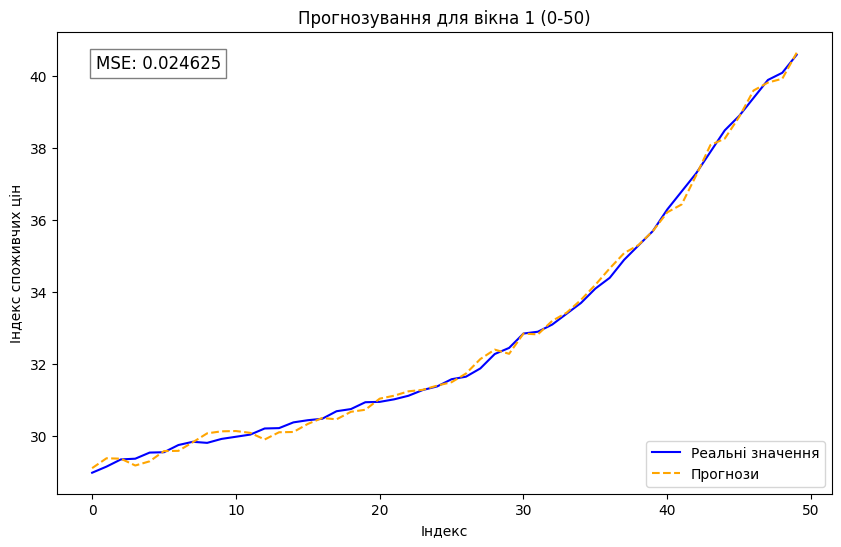

Training on window 2 (1-51)


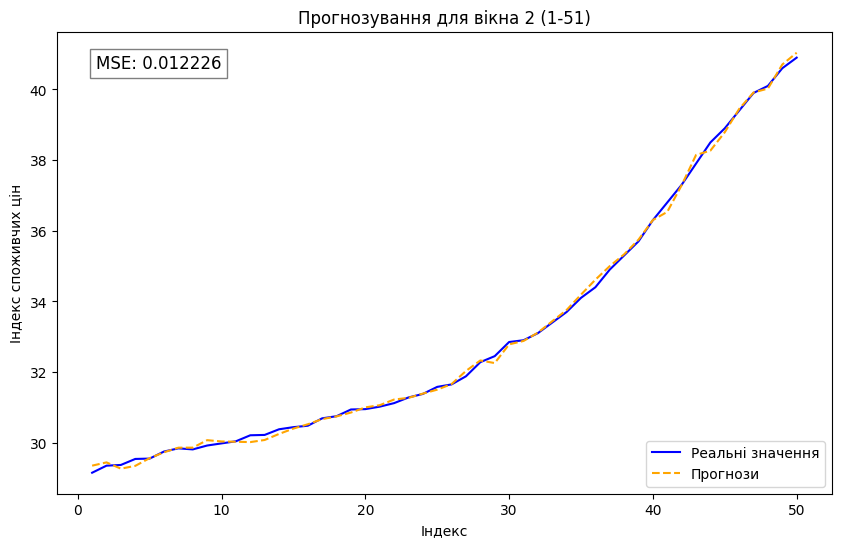

Training on window 3 (2-52)


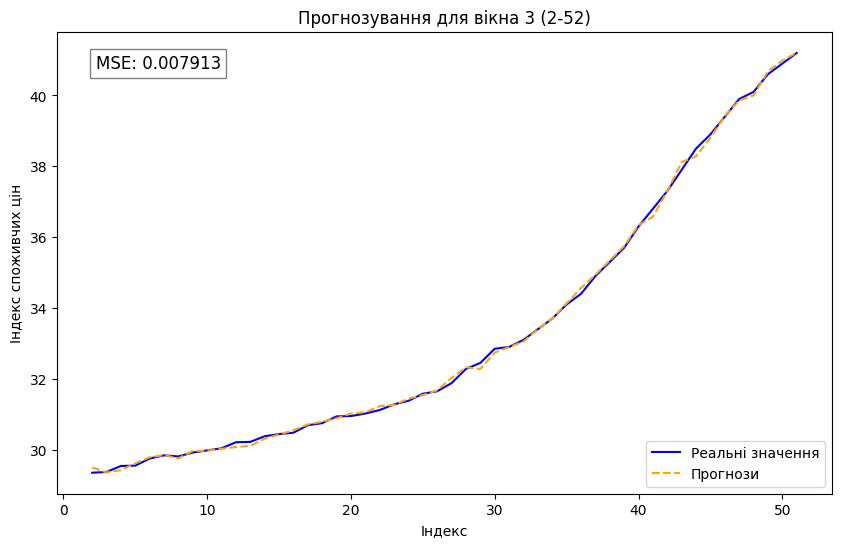

Training on window 4 (3-53)


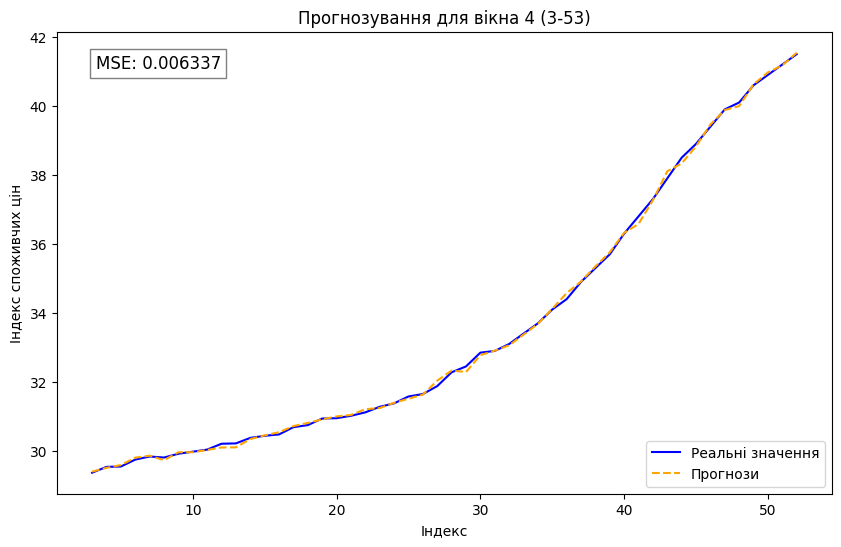

Training on window 5 (4-54)


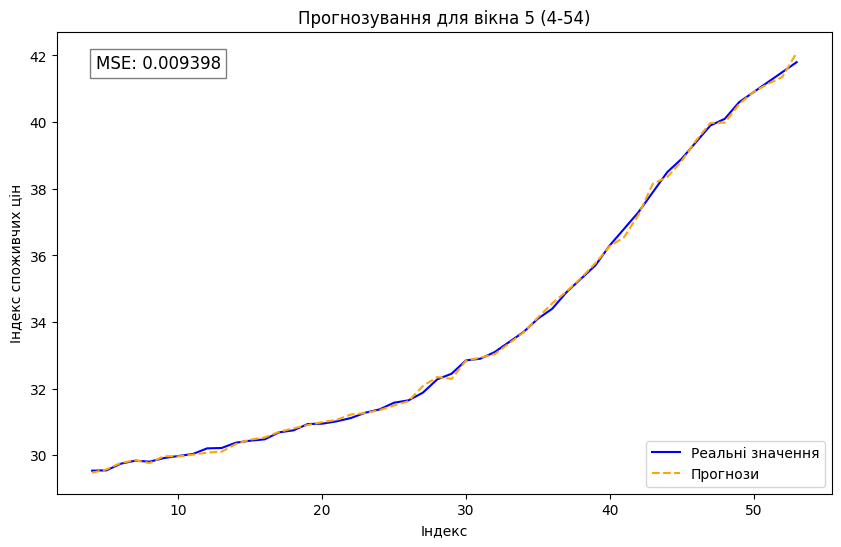

Training on window 6 (5-55)


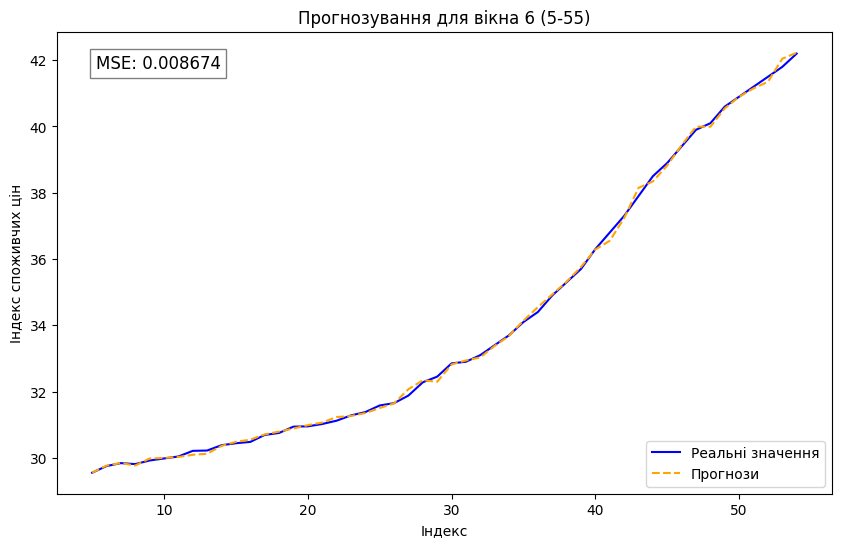

Training on window 7 (6-56)


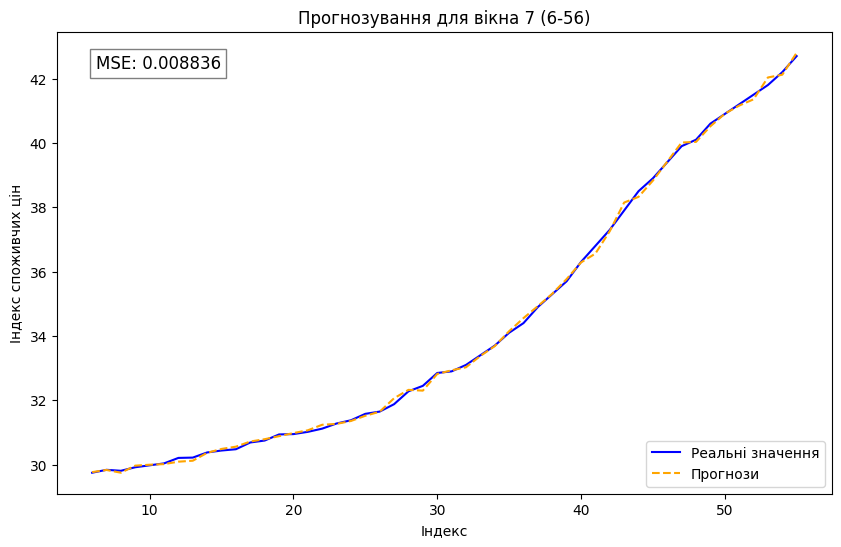

Training on window 8 (7-57)


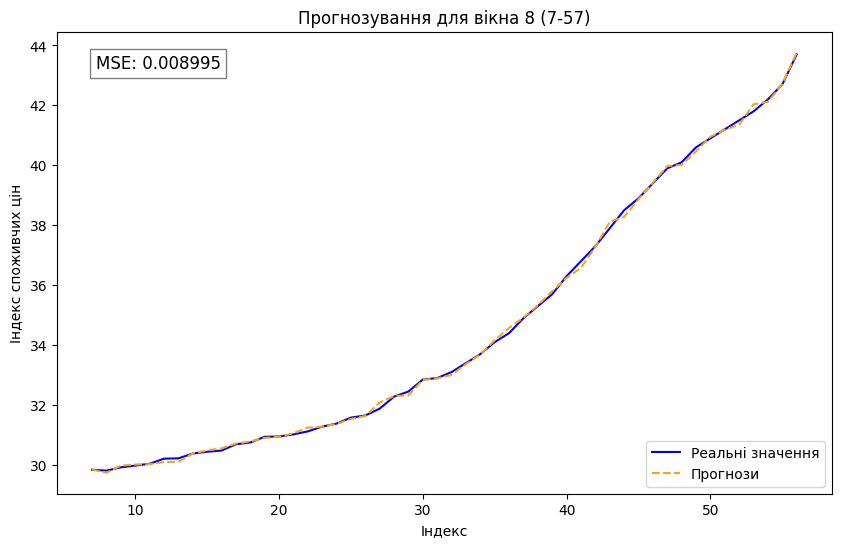

Training on window 9 (8-58)


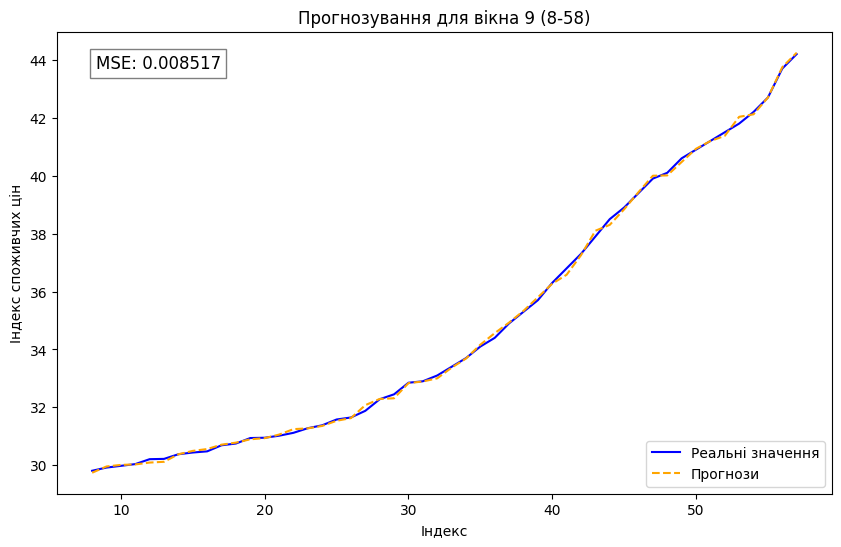

Training on window 10 (9-59)


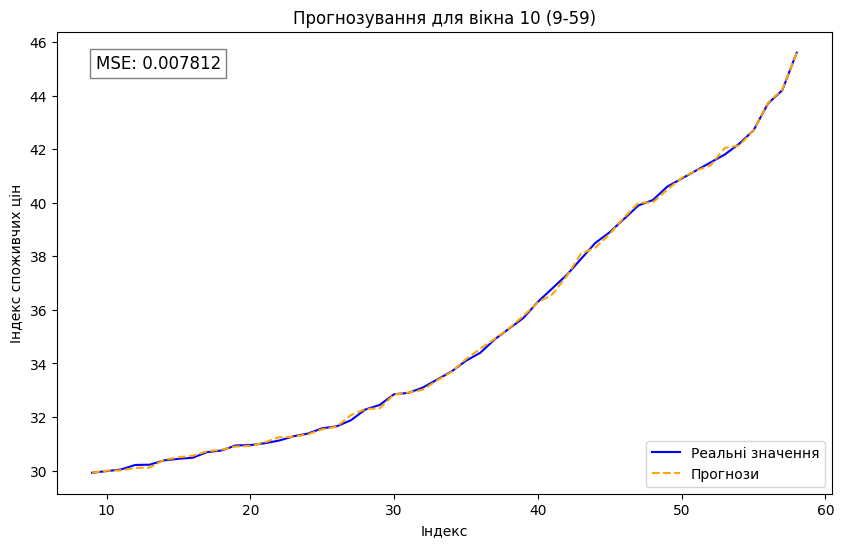

In [6]:
folder = 'full'
os.makedirs(folder, exist_ok=True)
 
sliding_window_training(X, y, folder, window_size=50, num_windows=10)

In [7]:
X = data[['realgdp', 'realcons', 'realinv', 'realgovt',
          'realdpi']].values
y = data['cpi'].values

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

In [8]:
X = X_scaled 
y = y_scaled 

# Initialize model
model = SimpleNN(input_size=X.shape[1], hidden_size=20, output_size=1)

Training on window 1 (0-50)


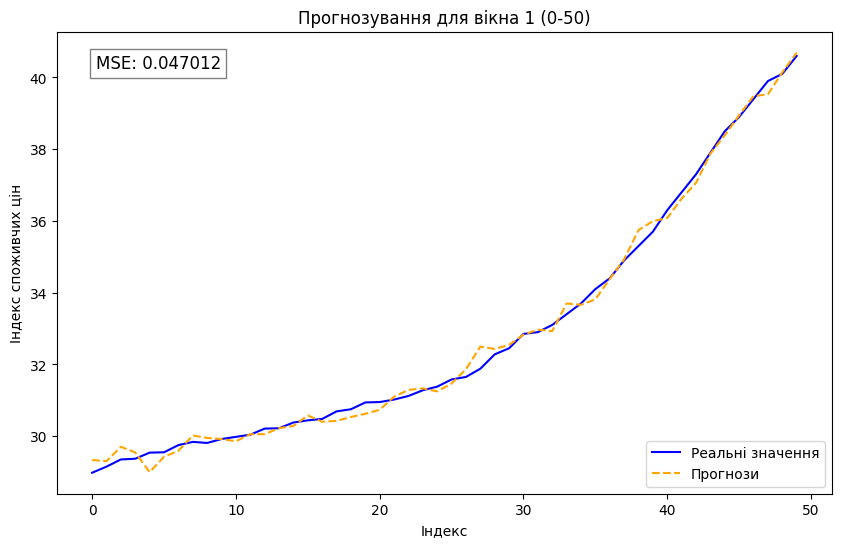

Training on window 2 (1-51)


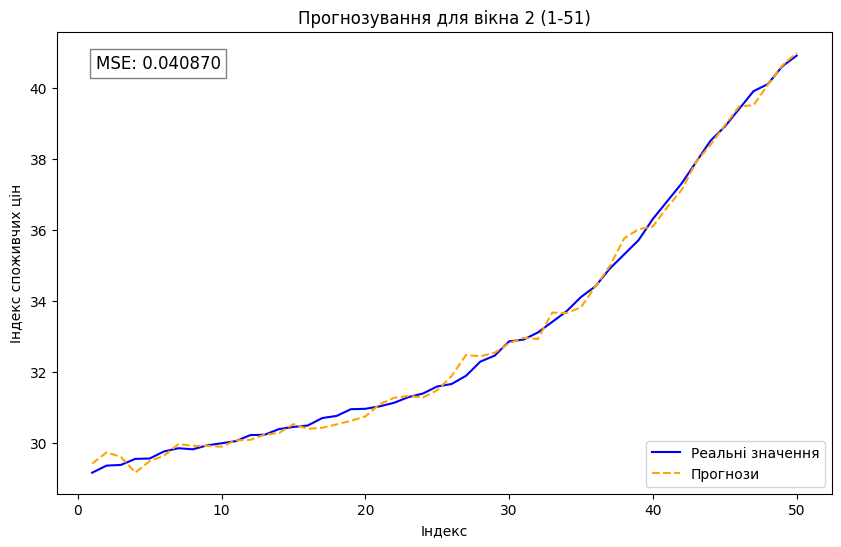

Training on window 3 (2-52)


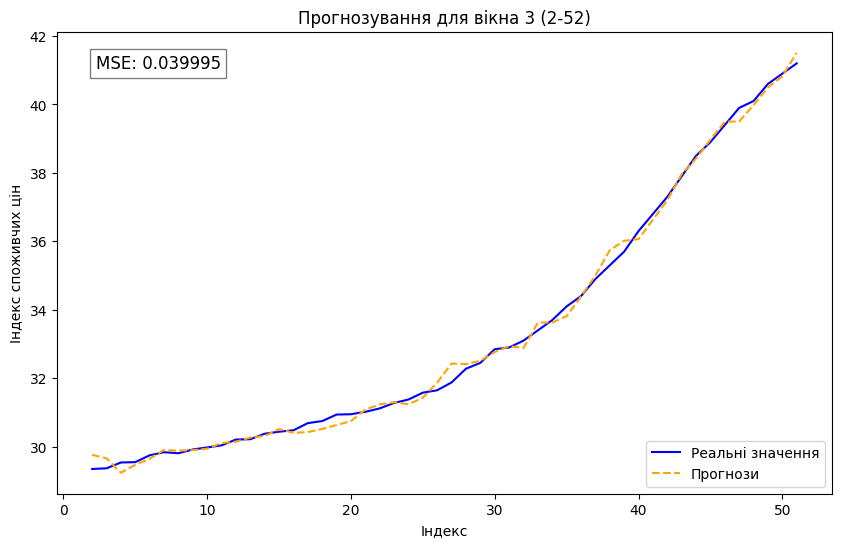

Training on window 4 (3-53)


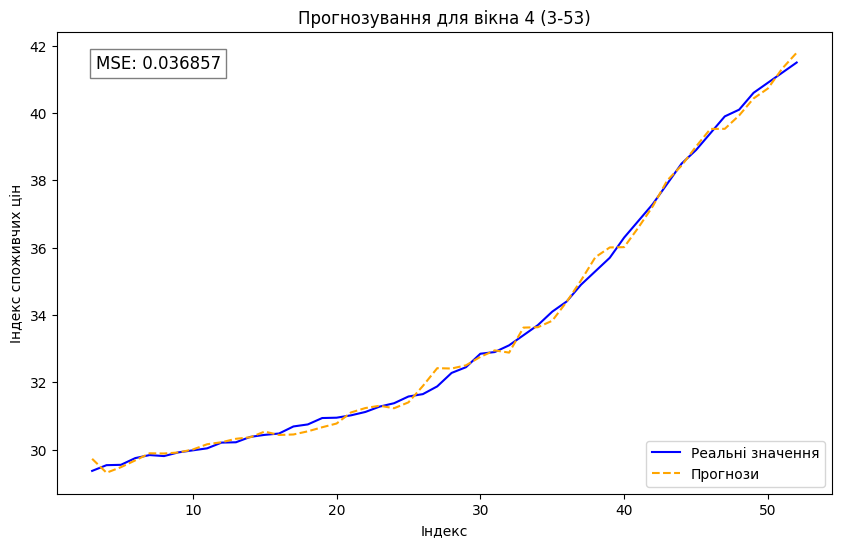

Training on window 5 (4-54)


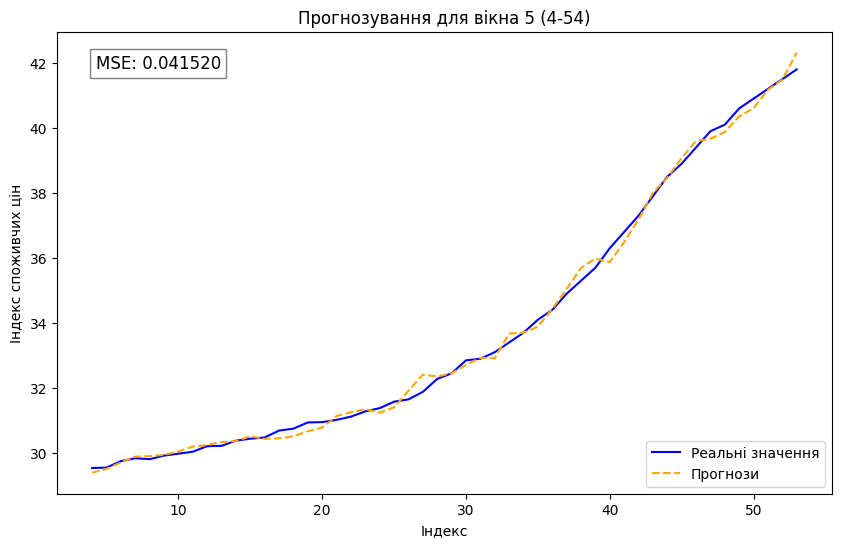

Training on window 6 (5-55)


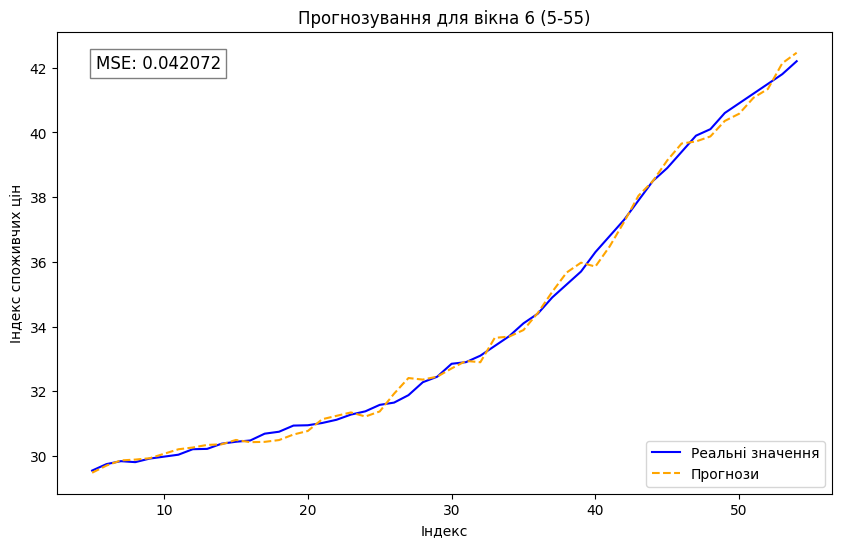

Training on window 7 (6-56)


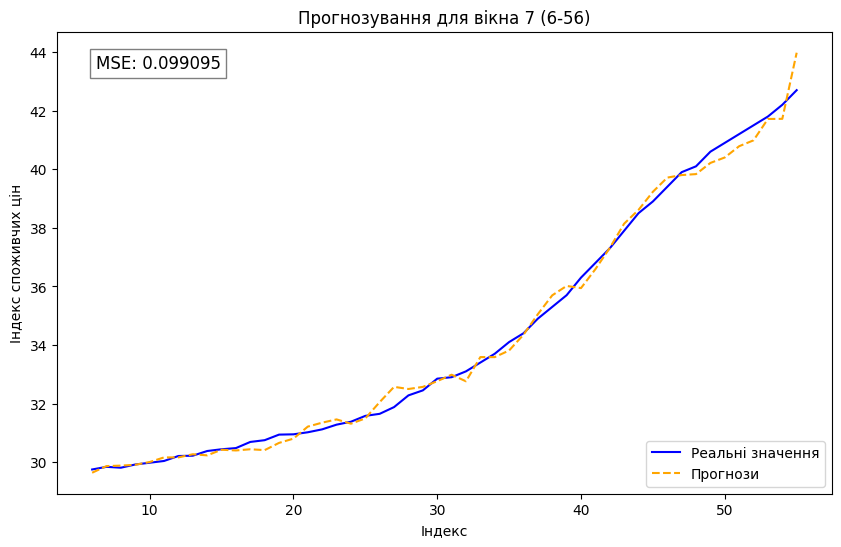

Training on window 8 (7-57)


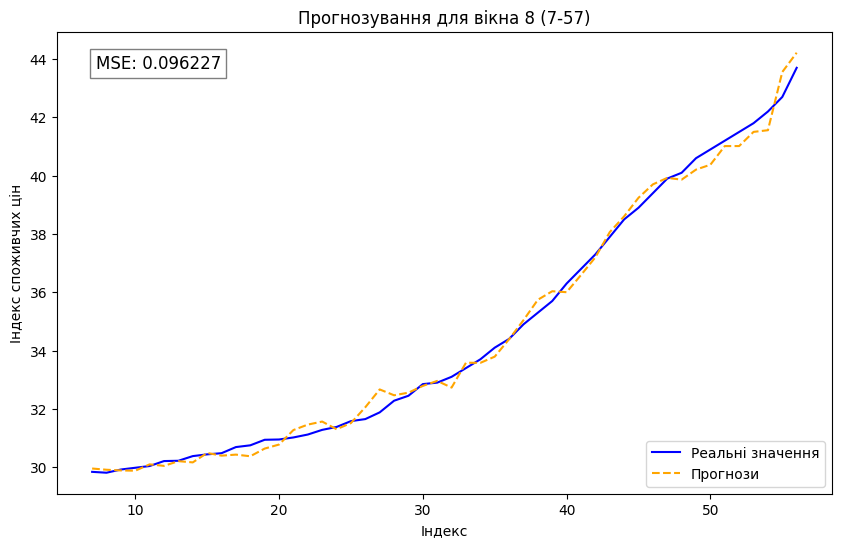

Training on window 9 (8-58)


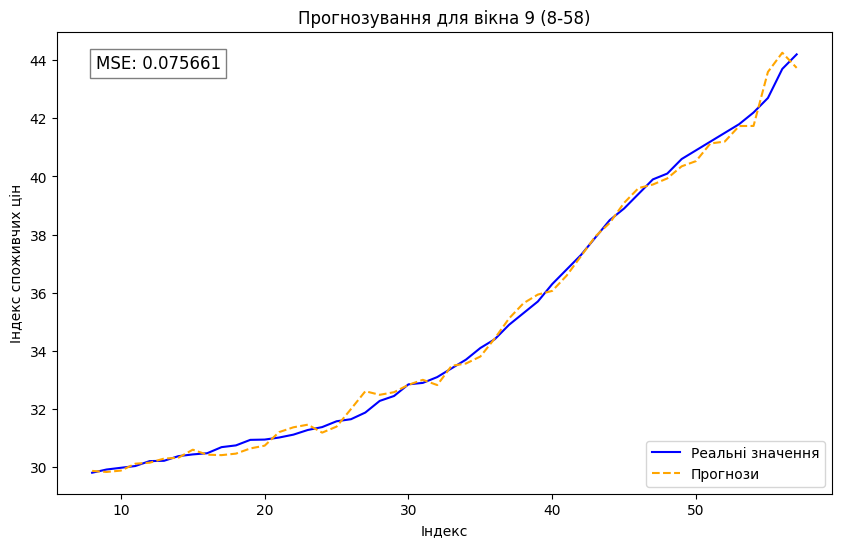

Training on window 10 (9-59)


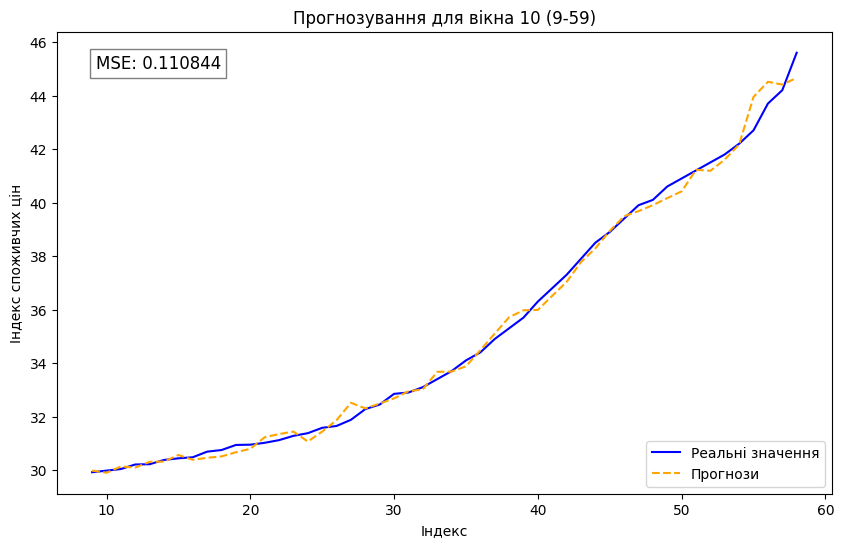

In [9]:
folder = 'partial'
os.makedirs(folder, exist_ok=True)
 
sliding_window_training(X, y, folder, window_size=50, num_windows=10)